In [186]:
import scanpy as sc
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np 
import zss


In [187]:
datasets = ['Hepatoblast-differentiation_yang',
           'Human-embryos_petropoulos',
           'Mouse-cell-atlas-combination-8',
           'Oligodendrocyte',
           'Planaria-full_plass',
           'Planaria-pair-10_plass']

roots={'Hepatoblast-differentiation_yang': 'E10.5',
           'Human-embryos_petropoulos': 'embryonic day 3',
           'Mouse-cell-atlas-combination-8': 'MEF(Trophoblast-Stem-Cell)',
           'Oligodendrocyte': 'OPC',
           'Planaria-full_plass': 'neoblast 1',
           'Planaria-pair-10_plass': 'neoblast 1'}

In [333]:
dataset = datasets[5]

DATA_PATH = '/projectnb/czlab/A00/ycliu/scRNA_trajectory_benchmark_datasets/'

RESULT_PATH = '/projectnb/czproj/Algorithms/ycliu/scDiffusion/outputs/traj_outputs/' + dataset + '/'

OUTPUT_PATH = '/projectnb/czproj/Algorithms/ycliu/scDiffusion/outputs/traj_outputs/score/'


# Load data

In [334]:
# Loading the dataset

print(dataset+': ')
print('  ')
adata = sc.read_h5ad(RESULT_PATH+'Scanpy_PAGA.h5ad')

adata


Planaria-pair-10_plass: 
  


AnnData object with n_obs × n_vars = 14636 × 2000
    obs: 'labels', 'dpt_pseudotime'
    var: 'gene_ids', 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'benchmark_traj', 'diffmap_evals', 'hvg', 'iroot', 'labels_colors', 'labels_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# UMAP

/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


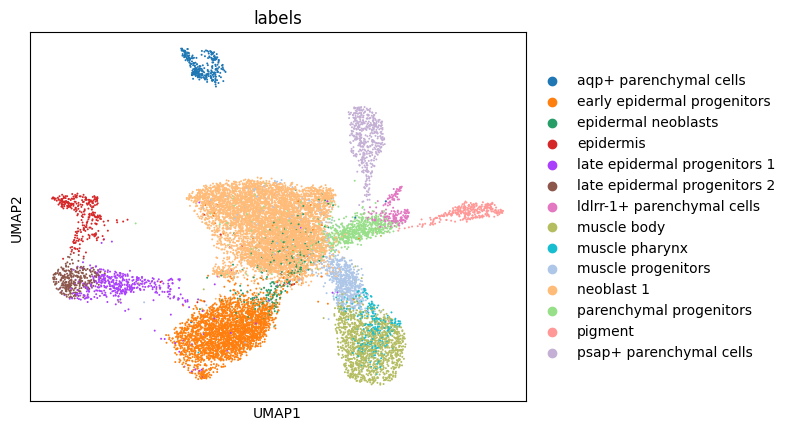

In [335]:
sc.pl.umap(adata, color=['labels'])

# Benchmark trajectory

In [336]:
# Load the benchmark trajectory 
benchmark_traj_df = pd.read_csv(DATA_PATH + dataset + '/benchmark_traj.csv')

benchmark_traj_df




,Unnamed: 0,from,to,length,directed
0,1,neoblast 1,epidermal neoblasts,1,True
1,2,neoblast 1,parenchymal progenitors,1,True
2,3,neoblast 1,muscle progenitors,1,True
3,4,epidermal neoblasts,early epidermal progenitors,1,True
4,5,early epidermal progenitors,late epidermal progenitors 1,1,True
5,6,late epidermal progenitors 1,late epidermal progenitors 2,1,True
6,7,late epidermal progenitors 2,epidermis,1,True
7,8,parenchymal progenitors,pigment,1,True
8,9,parenchymal progenitors,aqp+ parenchymal cells,1,True
9,10,parenchymal progenitors,psap+ parenchymal cells,1,True


In [337]:
len(benchmark_traj_df)

13

In [338]:
def traj_dict(df):
    graph = {}
    for i, row in df.iterrows():
        graph[row['to']] = row['from']
        
    return graph

In [339]:
bm_traj_dict = traj_dict(benchmark_traj_df)
bm_traj_dict

{'epidermal neoblasts': 'neoblast 1',
 'parenchymal progenitors': 'neoblast 1',
 'muscle progenitors': 'neoblast 1',
 'early epidermal progenitors': 'epidermal neoblasts',
 'late epidermal progenitors 1': 'early epidermal progenitors',
 'late epidermal progenitors 2': 'late epidermal progenitors 1',
 'epidermis': 'late epidermal progenitors 2',
 'pigment': 'parenchymal progenitors',
 'aqp+ parenchymal cells': 'parenchymal progenitors',
 'psap+ parenchymal cells': 'parenchymal progenitors',
 'ldlrr-1+ parenchymal cells': 'parenchymal progenitors',
 'muscle body': 'muscle progenitors',
 'muscle pharynx': 'muscle progenitors'}

# Evaluation metrics

In [340]:
# tree edit distance
from math import inf
        
class TreeNode:
    def __init__(self, label):
        self.label = label
        self.children = []

def build_tree_from_edges(edges, root_node):
    nodes = {}
    for parent, child in edges:
        if parent not in nodes:
            nodes[parent] = TreeNode(parent)
        if child not in nodes:
            nodes[child] = TreeNode(child)
        nodes[parent].children.append(nodes[child])
    return nodes[root_node]  # Return the root node


def insert_cost(node):
    return 1

def remove_cost(node):
    return 1

def update_cost(node1, node2):
    return 0 if node1.label == node2.label else inf




In [341]:
# graph edit distance

import networkx as nx

def graph_edit_distance(G1, G2):
        
    # Initialize cost for edges
    node_cost = 0
    nodes1 = set(G1.nodes)
    nodes2 = set(G2.nodes)

    # Calculate edge substitution cost
    for node1 in nodes1:
        if node1 in nodes2:
            nodes2.remove(node1)  # Matched edges
        else:
            node_cost += 1  # Unmatched edge in G1 (deletion)

    node_cost += len(nodes2)  # Remaining unmatched edges in G2 (insertion)

    # Initialize cost for edges
    edge_cost = 0
    edges1 = set(G1.edges)
    edges2 = set(G2.edges)

    # Calculate edge substitution cost
    for edge1 in edges1:
        if edge1 in edges2:
            edges2.remove(edge1)  # Matched edges
        else:
            edge_cost += 1  # Unmatched edge in G1 (deletion)

    edge_cost += len(edges2)  # Remaining unmatched edges in G2 (insertion)

    return node_cost + edge_cost


In [342]:
# Graph kernel score

import networkx as nx
from grakel import GraphKernel, Graph

def graph_kernel_score(edges1, edges2, root_node):
    
    edges1 = find_root_node(edges1, root_node)
    edges2 = find_root_node(edges2, root_node)

    G1 = nx.Graph()
    G1.add_edges_from(edges1)

    G2 = nx.Graph()
    G2.add_edges_from(edges2)
    
    grakel_G1 = nx_to_grakel(G1)
    grakel_G2 = nx_to_grakel(G2)

    # Initialize the Weisfeiler-Lehman subtree kernel
    gk = GraphKernel(kernel={"name": "shortest_path"}, normalize=True)

    # Compute the kernel matrix
    G = [grakel_G1, grakel_G2]
    K = gk.fit_transform(G)
    
    final_score = K[0,1]
    
    return final_score

# Convert NetworkX graphs to Grakel format
def nx_to_grakel(G):
    nodes = list(G.nodes)
    edges = list(G.edges)
    node_labels = {node: i for i, node in enumerate(nodes)}
    edges_transformed = [(node_labels[edge[0]], node_labels[edge[1]]) for edge in edges]
    return (edges_transformed, {i: label for label, i in node_labels.items()})


def find_root_node(edges1, root_node):
    if edges1[0][0] == root_node:
        pass

    else:
        for i in range(1, len(edges1)):
            if edges1[i][0] == root_node:
                aaa = edges1[0]
                edges1[0] = edges1[i]
                edges1[i] = aaa
                i = len(edges1)+1
            else:
                pass
            
    return edges1


# Load trajectory results

In [343]:
packages = ['scDiffusion', 'PAGA', 'Monocle3', 'MST', 'Slingshot', 'Slingshot_start', 'RaceID']

In [344]:
print(dataset + ': ')
print('   ')

data = {}

data['index'] = ['Graph edit index', 'Graph kernel index', 'Jaccard similarity index', 'AvgTraj']



if dataset == 'Planaria-full_plass':
    packages = ['scDiffusion', 'PAGA', 'Slingshot', 'Slingshot_start', 'RaceID']
    

for package in packages:

    traj = pd.read_csv(RESULT_PATH + package + '.csv')
    package_traj_dict = traj_dict(traj)

    bm_traj_ls = []
    for key in bm_traj_dict.keys():
        bm_traj_ls.append((bm_traj_dict[key], key)) 
        
    package_traj_ls = []
    for key in package_traj_dict.keys():
        package_traj_ls.append((package_traj_dict[key], key)) 
    
    bm_traj_ls = sorted(bm_traj_ls, key=lambda edge: (edge[0], edge[1]))
    package_traj_ls = sorted(package_traj_ls, key=lambda edge: (edge[0], edge[1]))
    
    # Calculate the graph edit distance
    G1 = nx.DiGraph()
    G1.add_edges_from(bm_traj_ls)

    G2 = nx.DiGraph()
    G2.add_edges_from(package_traj_ls)

    
    distance = graph_edit_distance(G1, G2)
    
    max_distance = 2*len(bm_traj_dict.keys()) + 1
    
    gei = (max_distance-distance)/max_distance
    
    # graph_kernel_score
    gki = graph_kernel_score(bm_traj_ls, package_traj_ls, root_node=roots[dataset])
    
    
    # Jaccard 
    total_n = len(bm_traj_dict.keys()) + len(package_traj_dict.keys())
    nn = 0
    for key in bm_traj_dict.keys():
        if key in package_traj_dict.keys():
            if bm_traj_dict[key] == package_traj_dict[key]:
                nn += 1
                
    total_n = total_n - nn
    
    jsi = nn/total_n
    
    mean = (gei+gki+jsi)/3
    
    score = [gei, gki, jsi, mean]
    
    data[package] = score
    
    
#     print(package + ' score: ')
#     print(f"Graph Edit Distance: {score}")    

import pandas as pd
df = pd.DataFrame(data)

df = df.set_index('index')

df.to_csv(OUTPUT_PATH + dataset + '.csv')

print(df)


Planaria-pair-10_plass: 
   
                          scDiffusion      PAGA  Monocle3       MST  \
index                                                                 
Graph edit index             0.851852  0.703704  0.629630  0.555556   
Graph kernel index           0.758621  0.387905  0.383571  0.440741   
Jaccard similarity index     0.733333  0.529412  0.500000  0.368421   
AvgTraj                      0.781269  0.540340  0.504400  0.454906   

                          Slingshot  Slingshot_start    RaceID  
index                                                           
Graph edit index           0.629630         0.777778  0.407407  
Graph kernel index         0.530669         0.542082  0.158362  
Jaccard similarity index   0.444444         0.625000  0.238095  
AvgTraj                    0.534914         0.648287  0.267955  


## Tree edit distance

In [457]:
print(dataset + ': ')
print('   ')

import random

if dataset == 'Planaria-full_plass':
    packages = ['scDiffusion', 'PAGA', 'Slingshot', 'Slingshot_start']
    

for package in packages:

    traj = pd.read_csv(RESULT_PATH + package + '.csv')
    package_traj_dict = traj_dict(traj)

    bm_traj_ls = []
    for key in bm_traj_dict.keys():
        bm_traj_ls.append((bm_traj_dict[key], key)) 
        
    package_traj_ls = []
    for key in package_traj_dict.keys():
        package_traj_ls.append((package_traj_dict[key], key)) 
    
    bm_traj_ls = sorted(bm_traj_ls, key=lambda edge: (edge[0], edge[1]))
    package_traj_ls = sorted(package_traj_ls, key=lambda edge: (edge[0], edge[1]))
        
    # Build trees from edge lists
    bm_tree = build_tree_from_edges(bm_traj_ls, roots[dataset])
    package_tree = build_tree_from_edges(package_traj_ls, roots[dataset])

    # Calculate tree edit distance
    #distance = tree_edit_distance(package_tree, bm_tree)
    
    distance = zss.distance(
        package_tree, bm_tree,
        get_children=lambda node: node.children,
        insert_cost=insert_cost,
        remove_cost=remove_cost,
        update_cost=update_cost
    )
    
    max_distance = 2*len(bm_traj_dict.keys())-2
    
    score = (max_distance-distance)/max_distance
    
    
    print(package + ' score: ')
    print(f"Tree Edit Distance: {score}")    
    

Hepatoblast-differentiation_yang: 
   
scDiffusion score: 
Tree Edit Distance: 0.8888888888888888
PAGA score: 
Tree Edit Distance: 0.8888888888888888
Monocle3 score: 
Tree Edit Distance: 0.7222222222222222
MST score: 
Tree Edit Distance: 0.6111111111111112
Slingshot score: 
Tree Edit Distance: 0.4444444444444444
Slingshot_start score: 
Tree Edit Distance: 0.7777777777777778


# Graph edit distance

In [458]:
print(dataset + ': ')
print('   ')

import random

if dataset == 'Planaria-full_plass':
    packages = ['scDiffusion', 'PAGA', 'Slingshot', 'Slingshot_start']
    

for package in packages:

    traj = pd.read_csv(RESULT_PATH + package + '.csv')
    package_traj_dict = traj_dict(traj)

    bm_traj_ls = []
    for key in bm_traj_dict.keys():
        bm_traj_ls.append((bm_traj_dict[key], key)) 
        
    package_traj_ls = []
    for key in package_traj_dict.keys():
        package_traj_ls.append((package_traj_dict[key], key)) 
    
    bm_traj_ls = sorted(bm_traj_ls, key=lambda edge: (edge[0], edge[1]))
    package_traj_ls = sorted(package_traj_ls, key=lambda edge: (edge[0], edge[1]))
        
    G1 = nx.DiGraph()
    G1.add_edges_from(bm_traj_ls)

    G2 = nx.DiGraph()
    G2.add_edges_from(package_traj_ls)

    # Calculate the graph edit distance
    distance = graph_edit_distance(G1, G2)
    
    max_distance = 4*len(bm_traj_dict.keys()) + 2
    
    score = (max_distance-distance)/max_distance
    
    
    print(package + ' score: ')
    print(f"Graph Edit Distance: {score}")    
    


Hepatoblast-differentiation_yang: 
   
scDiffusion score: 
Graph Edit Distance: 0.9047619047619048
PAGA score: 
Graph Edit Distance: 0.8333333333333334
Monocle3 score: 
Graph Edit Distance: 0.7619047619047619
MST score: 
Graph Edit Distance: 0.7857142857142857
Slingshot score: 
Graph Edit Distance: 0.5952380952380952
Slingshot_start score: 
Graph Edit Distance: 0.9047619047619048


## Jaccard similarity coefficient

In [459]:
print(dataset + ': ')
print('   ')

if dataset == 'Planaria-full_plass':
    packages = ['scDiffusion', 'PAGA', 'Slingshot', 'Slingshot_start']
    

for package in packages:

    traj = pd.read_csv(RESULT_PATH + package + '.csv')
    package_traj_dict = traj_dict(traj)
    
    total_n = len(bm_traj_dict.keys()) + len(package_traj_dict.keys())

    nn = 0
    for key in bm_traj_dict.keys():
        if key in package_traj_dict.keys():
            if bm_traj_dict[key] == package_traj_dict[key]:
                nn += 1
                
    total_n = total_n - nn

    print(package + ' score: ')
    print('          ', (nn/total_n))


Hepatoblast-differentiation_yang: 
   
scDiffusion score: 
           0.8181818181818182
PAGA score: 
           0.6666666666666666
Monocle3 score: 
           0.46153846153846156
MST score: 
           0.5833333333333334
Slingshot score: 
           0.25
Slingshot_start score: 
           0.6666666666666666


## Graph kernel score

In [460]:
print(dataset + ': ')
print('   ')


if dataset == 'Planaria-full_plass':
    packages = ['scDiffusion', 'PAGA', 'Slingshot', 'Slingshot_start']
    

for package in packages:

    traj = pd.read_csv(RESULT_PATH + package + '.csv')
    package_traj_dict = traj_dict(traj)
    
    bm_traj_ls = []
    for key in bm_traj_dict.keys():
        bm_traj_ls.append((bm_traj_dict[key], key)) 
        
    package_traj_ls = []
    for key in package_traj_dict.keys():
        package_traj_ls.append((package_traj_dict[key], key)) 
        
    bm_traj_ls = sorted(bm_traj_ls, key=lambda edge: (edge[0], edge[1]))
    package_traj_ls = sorted(package_traj_ls, key=lambda edge: (edge[0], edge[1]))
        

    score = graph_kernel_score(bm_traj_ls, package_traj_ls, root_node=roots[dataset])

    print(package + ' score: ')
    print('          ', (score))


Hepatoblast-differentiation_yang: 
   
scDiffusion score: 
           0.7634222834143518
PAGA score: 
           0.737097377089719
Monocle3 score: 
           0.5017452060042544
MST score: 
           0.6908817223234605
Slingshot score: 
           0.3595462477533374
Slingshot_start score: 
           0.4181210050035454


# Three metrics

In [461]:
print(dataset + ': ')
print('   ')

data = {}

data['index'] = ['Graph edit index', 'Graph kernel index', 'Jaccard similarity index', 'AvgTraj']



if dataset == 'Planaria-full_plass':
    packages = ['scDiffusion', 'PAGA', 'Slingshot', 'Slingshot_start']
    

for package in packages:

    traj = pd.read_csv(RESULT_PATH + package + '.csv')
    package_traj_dict = traj_dict(traj)

    bm_traj_ls = []
    for key in bm_traj_dict.keys():
        bm_traj_ls.append((bm_traj_dict[key], key)) 
        
    package_traj_ls = []
    for key in package_traj_dict.keys():
        package_traj_ls.append((package_traj_dict[key], key)) 
    
    bm_traj_ls = sorted(bm_traj_ls, key=lambda edge: (edge[0], edge[1]))
    package_traj_ls = sorted(package_traj_ls, key=lambda edge: (edge[0], edge[1]))
    
    # Calculate the graph edit distance
    G1 = nx.DiGraph()
    G1.add_edges_from(bm_traj_ls)

    G2 = nx.DiGraph()
    G2.add_edges_from(package_traj_ls)

    
    distance = graph_edit_distance(G1, G2)
    
    max_distance = 4*len(bm_traj_dict.keys()) + 2
    
    gei = (max_distance-distance)/max_distance
    
    # graph_kernel_score
    gki = graph_kernel_score(bm_traj_ls, package_traj_ls, root_node=roots[dataset])
    
    
    # Jaccard 
    total_n = len(bm_traj_dict.keys()) + len(package_traj_dict.keys())
    nn = 0
    for key in bm_traj_dict.keys():
        if key in package_traj_dict.keys():
            if bm_traj_dict[key] == package_traj_dict[key]:
                nn += 1
                
    total_n = total_n - nn
    
    jsi = nn/total_n
    
    mean = (gei+gki+jsi)/3
    
    score = [gei, gki, jsi, mean]
    
    data[package] = score
    
    
#     print(package + ' score: ')
#     print(f"Graph Edit Distance: {score}")    

import pandas as pd
df = pd.DataFrame(data)

df = df.set_index('index')

df.to_csv(OUTPUT_PATH + dataset + '.csv')

print(df)


Hepatoblast-differentiation_yang: 
   
                          scDiffusion      PAGA  Monocle3       MST  \
index                                                                 
Graph edit index             0.904762  0.833333  0.761905  0.785714   
Graph kernel index           0.763422  0.737097  0.501745  0.690882   
Jaccard similarity index     0.818182  0.666667  0.461538  0.583333   
AvgTraj                      0.828789  0.745699  0.575063  0.686643   

                          Slingshot  Slingshot_start  
index                                                 
Graph edit index           0.595238         0.904762  
Graph kernel index         0.359546         0.418121  
Jaccard similarity index   0.250000         0.666667  
AvgTraj                    0.401595         0.663183  


In [ ]:
# graph edit distance

import networkx as nx
from itertools import product

# Define the cost functions
def node_substitution_cost(node1, node2):
    return 0 if node1 == node2 else 1

def edge_substitution_cost(edge1, edge2):
    return 0 if edge1 == edge2 else 1

def graph_edit_distance(G1, G2):
    m, n = len(G1.nodes), len(G2.nodes)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Initialize cost matrix for nodes
    for i in range(1, m + 1):
        dp[i][0] = dp[i - 1][0] + 1  # Cost of deleting a node from G1
    for j in range(1, n + 1):
        dp[0][j] = dp[0][j - 1] + 1  # Cost of inserting a node to G2

    for i, j in product(range(1, m + 1), range(1, n + 1)):
        node1, node2 = list(G1.nodes)[i - 1], list(G2.nodes)[j - 1]
        dp[i][j] = min(
            dp[i - 1][j] + 1,  # Deletion
            dp[i][j - 1] + 1,  # Insertion
            dp[i - 1][j - 1] + node_substitution_cost(node1, node2)  # Substitution
        )

    # Initialize cost for edges
    edge_cost = 0
    edges1 = set(G1.edges)
    edges2 = set(G2.edges)

    # Calculate edge substitution cost
    for edge1 in edges1:
        if edge1 in edges2:
            edges2.remove(edge1)  # Matched edges
        else:
            edge_cost += 1  # Unmatched edge in G1 (deletion)

    edge_cost += len(edges2)  # Remaining unmatched edges in G2 (insertion)

    return dp[m][n] + edge_cost
